In [1]:
"""
This notebook analysis the Ego4d Long-term Action Anticipation (LTA)
splits separately. These are the annotated available subsets.
The annotations are linked to the meta-data json through video_uid.
"""

import json
import os.path as osp
import json
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

# Parsing dataframes from jsons

In [2]:
# Entire dataset Meta-data DF
meta_data_file_path = "/fb-agios-acai-efs/Ego4D/ego4d_data/ego4d.json"
with open(meta_data_file_path, 'r') as meta_data_file:
    meta_data_obj = json.load(meta_data_file)

# Convert to DF
pd.json_normalize(meta_data_obj) # L1 overview
video_df = pd.json_normalize(meta_data_obj['videos'])
video_df.head(n=20)

,video_uid,duration_sec,scenarios,split_em,split_av,split_fho,s3_path,manifold_path,origin_video_id,video_source,...,imu_metadata.component_metadata,imu_metadata.s3_path,imu_metadata.manifold_path,imu_metadata.missing_video_component_indices,imu_metadata.ds,gaze_metadata.component_metadata,gaze_metadata.s3_path,gaze_metadata.manifold_path,gaze_metadata.missing_video_component_indices,gaze_metadata.ds
0,77cc4654-4eec-44c6-af05-dbdf71f9a401,1247.13,"[Car - commuting, road trip, Talking with fami...",None,None,None,s3://ego4d-minnesota/public/v1/full_scale/77cc...,manifold://ego4d_fair/tree/intermediate/canoni...,subject00005_video00010,minnesota,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3e08beb0-9108-4e77-b2ae-80f91ceac474,603.83,[Crafting/knitting/sewing/drawing/painting],None,None,train,s3://ego4d-unict/public/v1/full_scale/3e08beb0...,manifold://ego4d_fair/tree/intermediate/canoni...,unict_005_0019,unict,...,[{'video_component_uid': '00020ae4-7654-4898-8...,s3://ego4d-unict/public/v1/imu/canonical/3e08b...,manifold://ego4d_fair/tree/imu/7/3e08beb0-9108...,[],1.646951e+09,NaN,NaN,NaN,NaN,NaN
2,6e389032-9216-4da0-8548-2f5087882589,1759.43,[],None,None,None,s3://ego4d-cmu/public/v1/full_scale/6e389032-9...,manifold://ego4d_fair/tree/intermediate/canoni...,P38_0256,cmu,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8a3c4a95-0492-41cf-802d-4198ab843582,1063.13,[],None,None,None,s3://ego4d-cmu/public/v1/full_scale/8a3c4a95-0...,manifold://ego4d_fair/tree/intermediate/canoni...,P38_0304,cmu,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c3f5972e-9919-496c-a01a-75ffa5c7bcff,238.13,[Carpenter],None,None,None,s3://ego4d-unict/public/v1/full_scale/c3f5972e...,manifold://ego4d_fair/tree/intermediate/canoni...,unict_018_4978,unict,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,a437e059-78be-4894-a7ab-dc27fa16d3f8,9879.30,"[Hiking, On a screen (phone/laptop), Talking w...",None,None,None,s3://ego4d-university-sa/public/v1/full_scale/...,manifold://ego4d_fair/tree/intermediate/canoni...,video_0052,uniandes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ab9b7b7c-33ad-4358-929f-8b36b719f45f,146.03,[Walking on street],None,None,None,s3://ego4d-kaust/public/v1/full_scale/ab9b7b7c...,manifold://ego4d_fair/tree/intermediate/canoni...,009_0620_0029,kaust,...,[{'video_component_uid': '7e101b24-ebf6-4a58-9...,s3://ego4d-kaust/public/v1/imu/canonical/ab9b7...,manifold://ego4d_fair/tree/imu/7/ab9b7b7c-33ad...,[],1.646951e+09,NaN,NaN,NaN,NaN,NaN
7,20bd786f-d222-4b0e-ad2c-a2381929cf78,2695.80,[Crafting/knitting/sewing/drawing/painting],None,None,None,s3://ego4d-unict/public/v1/full_scale/20bd786f...,manifold://ego4d_fair/tree/intermediate/canoni...,unict_020_0123,unict,...,[{'video_component_uid': '00100743-9302-42bc-8...,s3://ego4d-unict/public/v1/imu/canonical/20bd7...,manifold://ego4d_fair/tree/imu/7/20bd786f-d222...,[],1.646951e+09,NaN,NaN,NaN,NaN,NaN
8,0b637191-00b7-4fd8-af37-d26d80dc59ce,1364.62,[Eating],None,None,None,s3://ego4d-consortium-sharing/public/v1/full_s...,manifold://ego4d_fair/tree/intermediate/canoni...,20191112_160059_537_0000104,frl_track_1_public,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9b49246f-30e9-476f-ab8c-56a1bcb1d936,3553.03,"[Cleaning / laundry, Eating, Working at desk]",train,None,None,s3://ego4d-kaust/public/v1/full_scale/9b49246f...,manifold://ego4d_fair/tree/intermediate/canoni...,021_0628_0324,kaust,...,[{'video_component_uid': 'a722d762-1bfe-470b-8...,s3://ego4d-kaust/public/v1/imu/canonical/9b492...,manifold://ego4d_fair/tree/imu/7/9b49246f-30e9...,[],1.646951e+09,NaN,NaN,NaN,NaN,NaN


In [3]:
# Get annotation DF for Long Term Action Anticipation (LTA)
MODE='train' # train/test/val

annotation_file_names = [n.strip() for n in """
fho_lta_debug_val.json
fho_lta_taxonomy.json
fho_lta_test_unannotated.json
fho_lta_train.json
fho_lta_train_10000.json
fho_lta_train_5000.json
fho_lta_val.json
""".split('\n') if len(n)> 0]
print(annotation_file_names)

annotation_file_dir = "/fb-agios-acai-efs/Ego4D/ego4d_data/v1/annotations"
annotation_file_name = {'train':"fho_lta_train.json",'val':'fho_lta_val.json','test':'fho_lta_test_unannotated.json'}[MODE]
assert annotation_file_name in annotation_file_names
annotation_file_path = osp.join(annotation_file_dir, annotation_file_name)

with open(annotation_file_path, 'r') as annotation_file:
    annotation_obj = json.load(annotation_file)
    
# Check out the annotations
# print(annotation_obj.keys())
print(pd.json_normalize(annotation_obj).head(n=20))
"""
The annotation entries indicate a unique action in a timeframe of a specific video.
There are multiple clips 'clip_uid' (and hence actions) per 'video_uid', and multiple actions per clip_uid.
e.g. search on video_uid '9c59e912-2340-4400-b2df-7db3d4066723', resulting in 74 unique clip_uids
The 'action_idx'=k indicates the k-th action in that clip.
"""

# Convert clips to DF
labeled_clips_df = pd.json_normalize(annotation_obj['clips'])

# SELECT WHERE... examples for a single clip_id or video_uid
# labeled_clips_df.loc[labeled_clips_df['clip_id'] == 1805] # SELECT WHERE...
# labeled_clips_df.loc[labeled_clips_df['video_uid'] == '8b72b54f-f87c-4fdb-84dc-97e42ab111ac'] # SELECT WHERE...
print(labeled_clips_df.head(n=20))

['fho_lta_debug_val.json', 'fho_lta_taxonomy.json', 'fho_lta_test_unannotated.json', 'fho_lta_train.json', 'fho_lta_train_10000.json', 'fho_lta_train_5000.json', 'fho_lta_val.json']
  version    date                                        description  split  \
0     1.0  220217  Ego4d Long Term Anticipation Forecasting Annot...  train   

                                               clips  
0  [{'video_uid': '9c59e912-2340-4400-b2df-7db3d4...  
                               video_uid  \
0   9c59e912-2340-4400-b2df-7db3d4066723   
1   9c59e912-2340-4400-b2df-7db3d4066723   
2   9c59e912-2340-4400-b2df-7db3d4066723   
3   9c59e912-2340-4400-b2df-7db3d4066723   
4   9c59e912-2340-4400-b2df-7db3d4066723   
5   9c59e912-2340-4400-b2df-7db3d4066723   
6   9c59e912-2340-4400-b2df-7db3d4066723   
7   9c59e912-2340-4400-b2df-7db3d4066723   
8   9c59e912-2340-4400-b2df-7db3d4066723   
9   9c59e912-2340-4400-b2df-7db3d4066723   
10  9c59e912-2340-4400-b2df-7db3d4066723   
11  9c59e912-2340-440

# Looking into the meta-data

In [4]:
# Meta-data summary per user
# Group by user (fb_participant_id) and accumulate video_count/duration/scenarios
# Null/unassigned users are omitted automatically

scenarios_per_user_df = video_df.groupby(video_df['fb_participant_id'], as_index=False).agg({'scenarios':list,'video_uid':'count','duration_sec':'sum'})
scenarios_per_user_df['scenarios'] = scenarios_per_user_df['scenarios'].apply(np.concatenate).apply(Counter) # FLATTEN
scenarios_per_user_df = scenarios_per_user_df.rename(columns={"video_uid":"video_count"})
scenarios_per_user_df

,fb_participant_id,scenarios,video_count,duration_sec
0,8.0,{'Crafting/knitting/sewing/drawing/painting': 8},8,22002.95
1,9.0,"{'Playing cards': 1, 'Gardening': 2}",3,3875.60
2,10.0,"{'Household management - caring for kids': 4, ...",10,8202.33
3,11.0,"{'Household management - caring for kids': 37,...",38,27094.81
4,12.0,{'Crafting/knitting/sewing/drawing/painting': 23},23,39797.95
...,...,...,...,...
808,872.0,{'Climbing': 2},2,11913.56
809,873.0,{'Climbing': 2},2,4961.87
810,874.0,{'Climbing': 1},1,2930.60
811,875.0,"{'On a screen (phone/laptop)': 1, 'Tourism': 1...",1,3093.23


## About the annotations
There is one entry per supervision-label. This may contain multiple clips and multiple video fragments.
A clip can be a sub-video of the parent video (probably because some videos very long for continuous labeling). One clip_id has multiple entries for all actions happening in that clip.

The action label is identified by ('verb','noun') or ('verb_label','noun_label'). Don't use 'action_idx', this indicates the 'action-idx'-th action in a clip (action counter)!

Multiple actions can happen at the same time! (Overlap in clip time ranges)

Through the video_uid we can link the annotations to the user. (Linking meta-data with the annotation-data).


# Linking the meta-data and annotation dataframes

In [5]:
# First link labels to videos - INNER JOIN of meta-object and labels-object
print(video_df.shape)
print(f"labels_df={labeled_clips_df.shape}")
joined_df = pd.merge(video_df, labeled_clips_df, on="video_uid",validate="one_to_many",how="inner") # Inner-join (Intersection of  video-uid values)
print(f"joined_df={joined_df.shape} -> Good, should have same #rows as labels-df, only keys are extended with info from meta-data object, such as user id etc")
joined_df

def duration_row_fn(x):
    video_uid_list = x[0]
    video_len_list = x[1]

    uniqe_video_uid_list, idxs = np.unique(video_uid_list,return_index=True)
    sum_unique_video_len = sum(np.asarray(video_len_list,dtype=np.float64)[idxs])

    return sum_unique_video_len
    
# Then group by user and aggregate columns
def group_innerjoin_by_user(joined_df):
    user_df = joined_df.copy(deep=True).groupby(joined_df['fb_participant_id'], as_index=False).agg(
        {'fb_participant_id':'first','scenarios':list,'verb':list,'noun':list, 'verb_label':list, 'noun_label':list,
         'video_uid':list,'duration_sec':list,'clip_id':list,'action_idx':list}) # VIDEO UID COUNT IS NOT CORRECT! Also counts non-uniques in join

    user_df['duration_sec_sum'] = user_df.loc[:,('video_uid','duration_sec')].apply(duration_row_fn, axis=1)
    user_df['video_count'] = user_df['video_uid'].apply(lambda x: len(np.unique(x))) # BUGFIX: we need only UNIQUE video_uids after inner_join
    user_df['scenarios'] = user_df['scenarios'].apply(np.concatenate) # FLATTEN
    user_df['action_count'] = user_df['action_idx'].apply(lambda x:len(x))
    user_df.drop('duration_sec', axis=1, inplace=True) # Make sure we don't use this one further on
    return user_df

user_df = group_innerjoin_by_user(joined_df)
user_df

(9645, 54)
labels_df=(23610, 20)
joined_df=(23610, 73) -> Good, should have same #rows as labels-df, only keys are extended with info from meta-data object, such as user id etc


,fb_participant_id,scenarios,verb,noun,verb_label,noun_label,video_uid,clip_id,action_idx,duration_sec_sum,video_count,action_count
0,8.0,"[Crafting/knitting/sewing/drawing/painting, Cr...","[paint, put_(place,_leave,_drop), take_(pick,_...","[cardboard_(cardboard,_paperboard), paintbrush...","[53, 65, 92, 19, 53, 53, 53, 65, 53, 19, 53, 5...","[68, 279, 279, 279, 286, 280, 469, 279, 280, 2...","[f6da2935-f18d-4ef4-9a50-8890d1cf796a, f6da293...","[1725, 1725, 1725, 1725, 1725, 1725, 1725, 172...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1319.57,1,18
1,9.0,"[Playing cards, Playing cards, Playing cards, ...","[take_(pick,_grab,_get), take_(pick,_grab,_get...","[card, card, card, card, card, card, card, foo...","[92, 92, 92, 58, 80, 92, 92, 92, 92, 92, 92, 5...","[67, 67, 67, 67, 67, 67, 67, 163, 163, 67, 67,...","[2c84e6a0-2a0b-4de8-ae99-aedbc871dffa, 2c84e6a...","[2863, 2863, 2863, 2863, 2863, 2863, 2863, 286...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3368.20,2,60
2,10.0,"[Household management - caring for kids, House...","[clean_(sweep,_scrub,_mop,_dust), clean_(sweep...","[rail_(rail,_railing), wood_(fiber,_firewood,_...","[9, 9, 9, 9, 9, 9, 9, 9, 49, 9, 9, 9, 9, 9, 9,...","[328, 469, 469, 469, 328, 469, 328, 469, 80, 4...","[0be30efe-9d71-4698-8304-f1d441aeea58, 0be30ef...","[2618, 2618, 2618, 2618, 2618, 2618, 2618, 261...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",6710.53,7,447
3,11.0,"[Household management - caring for kids, House...","[touch, dip, pour, touch, touch, paint, dip, p...","[bag_(bag,_grocery,_nylon,_polythene,_pouch,_s...","[98, 19, 60, 98, 98, 53, 19, 60, 65, 53, 65, 1...","[10, 279, 279, 10, 10, 469, 279, 279, 198, 328...","[18be74c1-9b20-41ca-8a89-7d0a1832ff55, 18be74c...","[2615, 2615, 2615, 2615, 2615, 2615, 2615, 261...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3152.95,3,33
4,12.0,"[Crafting/knitting/sewing/drawing/painting, Cr...","[take_(pick,_grab,_get), apply_(spread,_smear)...","[cardboard_(cardboard,_paperboard), cardboard_...","[92, 1, 16, 1, 92, 35, 92, 16, 65, 16, 65, 1, ...","[68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 6...","[38802829-2f8b-4023-b00e-23c00570b820, 3880282...","[1759, 1759, 1759, 1759, 1759, 1759, 1759, 175...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4081.56,2,160
...,...,...,...,...,...,...,...,...,...,...,...,...
163,462.0,[jobs related to construction/renovation compa...,"[turn_on_(switch_on,_start,_light), put_(place...","[cigarette_(cigarette,_vape), lighter, contain...","[101, 65, 65, 92, 3, 99, 50, 3, 27, 35, 50, 3,...","[91, 235, 105, 36, 36, 462, 448, 322, 322, 462...","[f131861d-c8df-4f78-b28e-7b82cc8d1270, f131861...","[3338, 3338, 3338, 3338, 3338, 3338, 3338, 333...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",714.67,2,98
164,463.0,"[Crafting/knitting/sewing/drawing/painting, Cr...","[cut_(trim,_slice,_chop), put_(place,_leave,_d...","[picture_(picture,_portrait), picture_(picture...","[16, 65, 92, 16, 65, 61]","[304, 304, 349, 304, 349, 300]","[db9805e6-c9fc-46bb-b0a9-c4025721cff0, db9805e...","[1561, 1561, 1561, 1561, 1561, 1561]","[0, 1, 2, 3, 4, 5]",739.77,1,6
165,464.0,[jobs related to construction/renovation compa...,"[tighten, hold_(support,_grip,_grasp), hold_(s...","[screw_(bolt,_nail,_screw), mower_(lawnmower,_...","[96, 35, 35, 34, 64, 96, 78, 50, 11, 92, 35, 3...","[352, 259, 259, 259, 259, 259, 259, 134, 134, ...","[32287654-7f5b-4d24-bdb0-5f0ceb6dfd24, 3228765...","[3360, 3360, 3360, 3360, 3360, 3360, 3360, 336...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",934.03,1,71
166,465.0,[jobs related to construction/renovation compa...,"[pour, scoop, pour, scoop, pour, put_(place,_l...","[soil_(dirt,_mud,_soil), soil_(dirt,_mud,_soil...","[60, 71, 60, 71, 60, 65, 42, 64, 65, 35, 64, 3...","[379, 379, 379, 379, 379, 366, 71, 71, 439, 71...","[d25c1a0b-c489-466c-aa24-9d7dd2df977e, d25c1a0...","[3301, 3301, 3301, 3301, 3301, 3301, 3301, 330...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,

# Convert (verb,noun) into actions and create Counter-columns

In [6]:
# MERGE (verb,noun) columns in_place
def create_action_labels_from_verbnoun(user_df):
    user_df['action_label'] = user_df.loc[:,('verb_label','noun_label')].apply(
        lambda x: [f"{l}-{r}" for l,r in zip(x[0],x[1])],
        axis=1
    )
    user_df['action'] = user_df.loc[:,('verb','noun')].apply(
        lambda x: [f"{l}-{r}" for l,r in zip(x[0],x[1])],
        axis=1
    )
    
# APPLY COUNTER OBJECTS ON ACTIONS
def create_counter_columns(df, cols=('action_label','action')):
    for col in cols:
        print(f"Created column Counter: {col}")
        df[f"{col}_count"] = df[col].apply(Counter)
        
def get_normalized_distr_actions(user_action_freq_df):
    user_action_freq_df['action_distr'] = user_action_freq_df['action_count'].apply(
        lambda x:sorted([el/sum(list(x.values())) for el in x.values()],reverse=True)
    )

    # Max nb of different scenarios for 1 user (for zero padding the rest for means/stds)
    max_action_list_len = user_action_freq_df['action_distr'].apply(len).max()
    print(max_action_list_len)

    # Append zero counts for others
    user_action_freq_df['action_distr'] = user_action_freq_df['action_distr'].apply(
        lambda x:np.pad(x,(0,max_action_list_len - len(x)))
    )

# In-place operations
create_action_labels_from_verbnoun(user_df)
create_counter_columns(user_df)
get_normalized_distr_actions(user_df)

user_action_freq_df = user_df

Created column Counter: action_label
Created column Counter: action
344


# Summarize actions per video

In [7]:
# Stats and checks on actions

# Calculate on avg how many actions on avg per video
# First avg over actions in video, then avg over users, or equivalent: #user-action/#user-videos
user_action_freq_df['actions_per_video'] = user_action_freq_df.loc[:,('video_count','action_count')].apply(
    lambda x: float(sum(x[1].values()))/float(x[0]), 
    axis=1)
print(f"We have {user_action_freq_df['actions_per_video'].mean()} actions/video avgd over users")

# Group labeled clips by unique_videos
print(f"video_df={video_df.shape}, labels_df={labeled_clips_df.shape}")
group_labeled_clips_df = labeled_clips_df.groupby(labeled_clips_df['video_uid'], as_index=False).agg(
    {'verb':list,'noun':list, 'verb_label':list, 'noun_label':list,'clip_id':list,'action_idx':list})
group_labeled_clips_df['action_count'] = group_labeled_clips_df['action_idx'].apply(lambda x: len(x))
print(group_labeled_clips_df.head(n=20))

# CHECK IF ALL ANNOTATION VIDEOS EXIST IN META-DATA DF
print("All video_uid's in annotations exist in the meta data object = {}".format(
(group_labeled_clips_df.video_uid.isin(video_df.video_uid) == True).all()
))

We have 47.56886574074074 actions/video avgd over users
video_df=(9645, 54), labels_df=(23610, 20)
                               video_uid  \
0   002d2729-df71-438d-8396-5895b349e8fd   
1   01db7c39-a512-4bac-b284-dff8c7360e80   
2   02995fb6-f8ac-4168-a60d-8a0b1a7210bd   
3   05e8b510-0973-4cbd-9a23-bf2c156b7958   
4   05f672ea-1651-4767-9c8a-0f504805e9c7   
5   062ded0e-1df8-42d1-adaa-fc948e1cd7de   
6   078f6bad-aa22-48bf-9df2-4d2f6ba7b556   
7   080657b3-7f23-4285-96ec-39136e58cdf1   
8   0836e1a4-11e6-4b31-bd39-f8e083fdadb3   
9   099f6f96-5aa7-4da8-a5e0-2e8bc03beee6   
10  0b24eb9e-a5ae-4389-b2cd-11fbf88e9c4a   
11  0b6fc89d-bf4b-44f3-82e7-67ee02517459   
12  0be30efe-9d71-4698-8304-f1d441aeea58   
13  0c192ca8-1ede-4ef0-a05e-2f4151b6bdfc   
14  0c8c2f4b-a006-47ca-8826-133af1dfb632   
15  0cb2dd94-afb1-4e30-a62f-724f34d81777   
16  0d8a3e5c-4263-4f80-b32d-39d4f33008ba   
17  0e6fb738-05fc-4dd5-9746-a8e10efe8c20   
18  0fbf42b1-23ed-4a2b-ad71-ab438b45e0d2   
19  0fe191ef-c28a-422

# Plot stacked barchart: Action distr per user

Stacked barchart plot entries (x=Users, y=user with max different actions)=((344, 168))


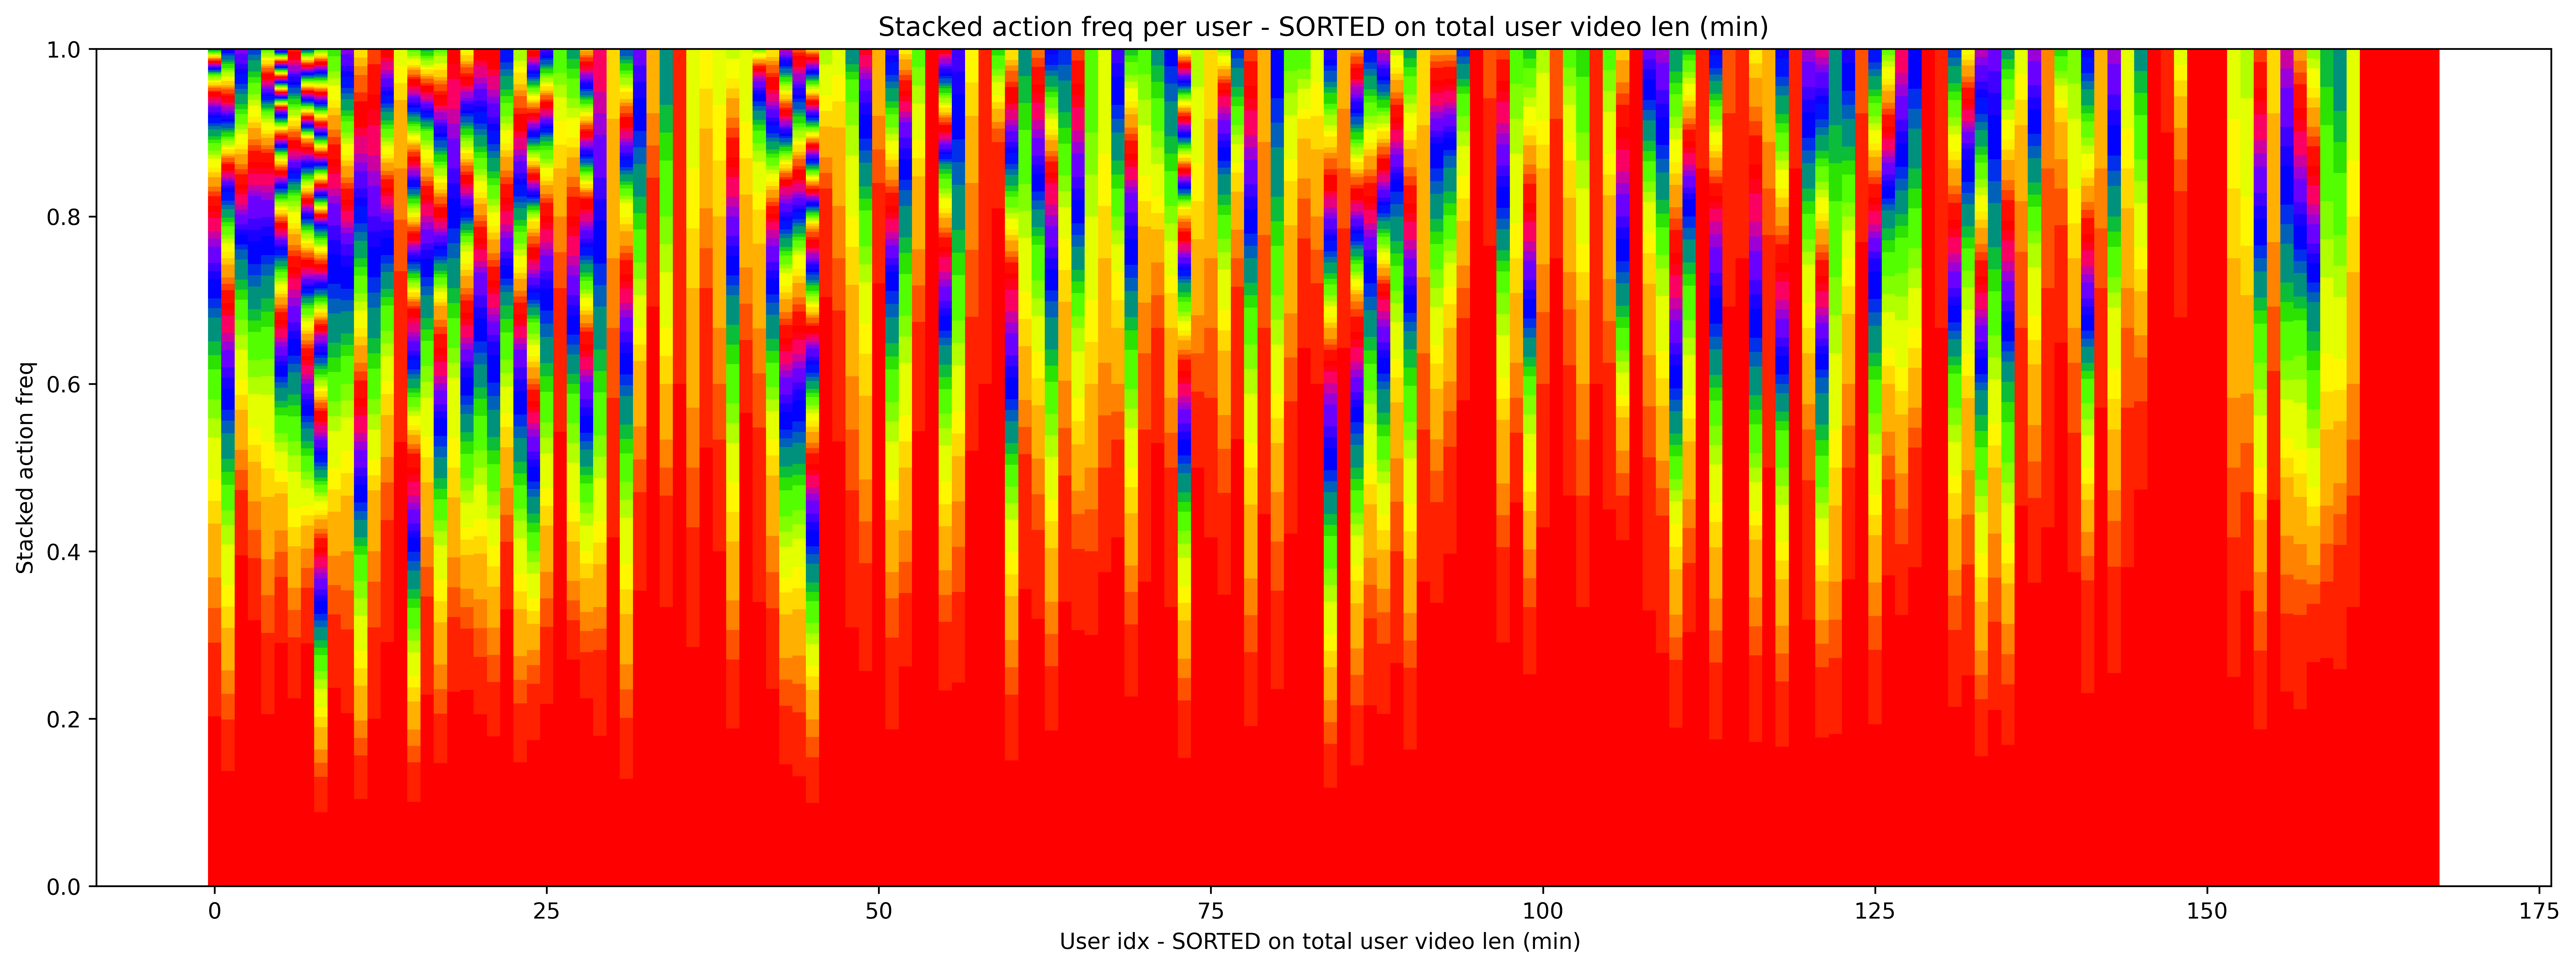

<Figure size 432x288 with 0 Axes>

In [8]:
# Other visualisation: users on x-axis and y-axis is multi-barplot where scenarios ordered on freq
def check_sum_one(list_of_distr):
    eps = 1e-5
    for distr in list_of_distr:
        prob_sum = sum(distr)
        assert 1-eps < prob_sum < 1 + eps, f"prob_sum={prob_sum} NOT SUMMING TO ONE"

def plot_useractions_stackedbarchart(user_action_freq_df):
    df_sorted = user_action_freq_df.sort_values(by=['duration_sec_sum'],ascending=False)
    video_lens_s = df_sorted['duration_sec_sum'].tolist()
    # print(df_sorted)

    # Stack bar plots: 
    stack_user_counts_s = df_sorted['action_distr'].tolist()
    check_sum_one(stack_user_counts_s)

    # Transpose: List of 1st entries over users, list of 2nd entries, etc
    stack_user_counts_st = np.asarray(stack_user_counts_s)
    check_sum_one(stack_user_counts_st)
    stack_user_counts_st = stack_user_counts_st.transpose()
    print(f"Stacked barchart plot entries (x=Users, y=user with max different actions)=({stack_user_counts_st.shape})")

    plt.figure(figsize=(20, 7), dpi=600) # So all bars are visible!
    x_axis = list(range(len(stack_user_counts_st[0])))

    # my_cmap = plt.get_cmap("hsv")
    my_cmap = plt.get_cmap("prism")
    color_steps = np.linspace(0, 1, len(stack_user_counts_st))

    # Config
    bar_width = 1

    # First bar
    prev_bar_values = stack_user_counts_st[0]
    plt.bar(x_axis, height=prev_bar_values, align='center', width=bar_width,color=my_cmap(color_steps[0]))
    for idx, stack_user_count in enumerate(stack_user_counts_st[1:]):
        color = my_cmap(color_steps[idx+1])
        plt.bar(x_axis, height=stack_user_count, color=color,bottom=prev_bar_values, align='center', width=bar_width)

        assert len(prev_bar_values) == len(stack_user_count.tolist())
        prev_bar_values = [x+y for x,y in zip(prev_bar_values,stack_user_count.tolist())]


    plt.ylim(None,None)
    plt.xlim(None,None)
    plt.xlabel("User idx - SORTED on total user video len (min) ")
    plt.ylabel("Stacked action freq")
    plt.title("Stacked action freq per user - SORTED on total user video len (min)")

    # plt.grid(grid)
    plt.show()
    plt.clf()
    
    return video_lens_s

video_lens_s = plot_useractions_stackedbarchart(user_action_freq_df)

# Plot barchart for total video length/user

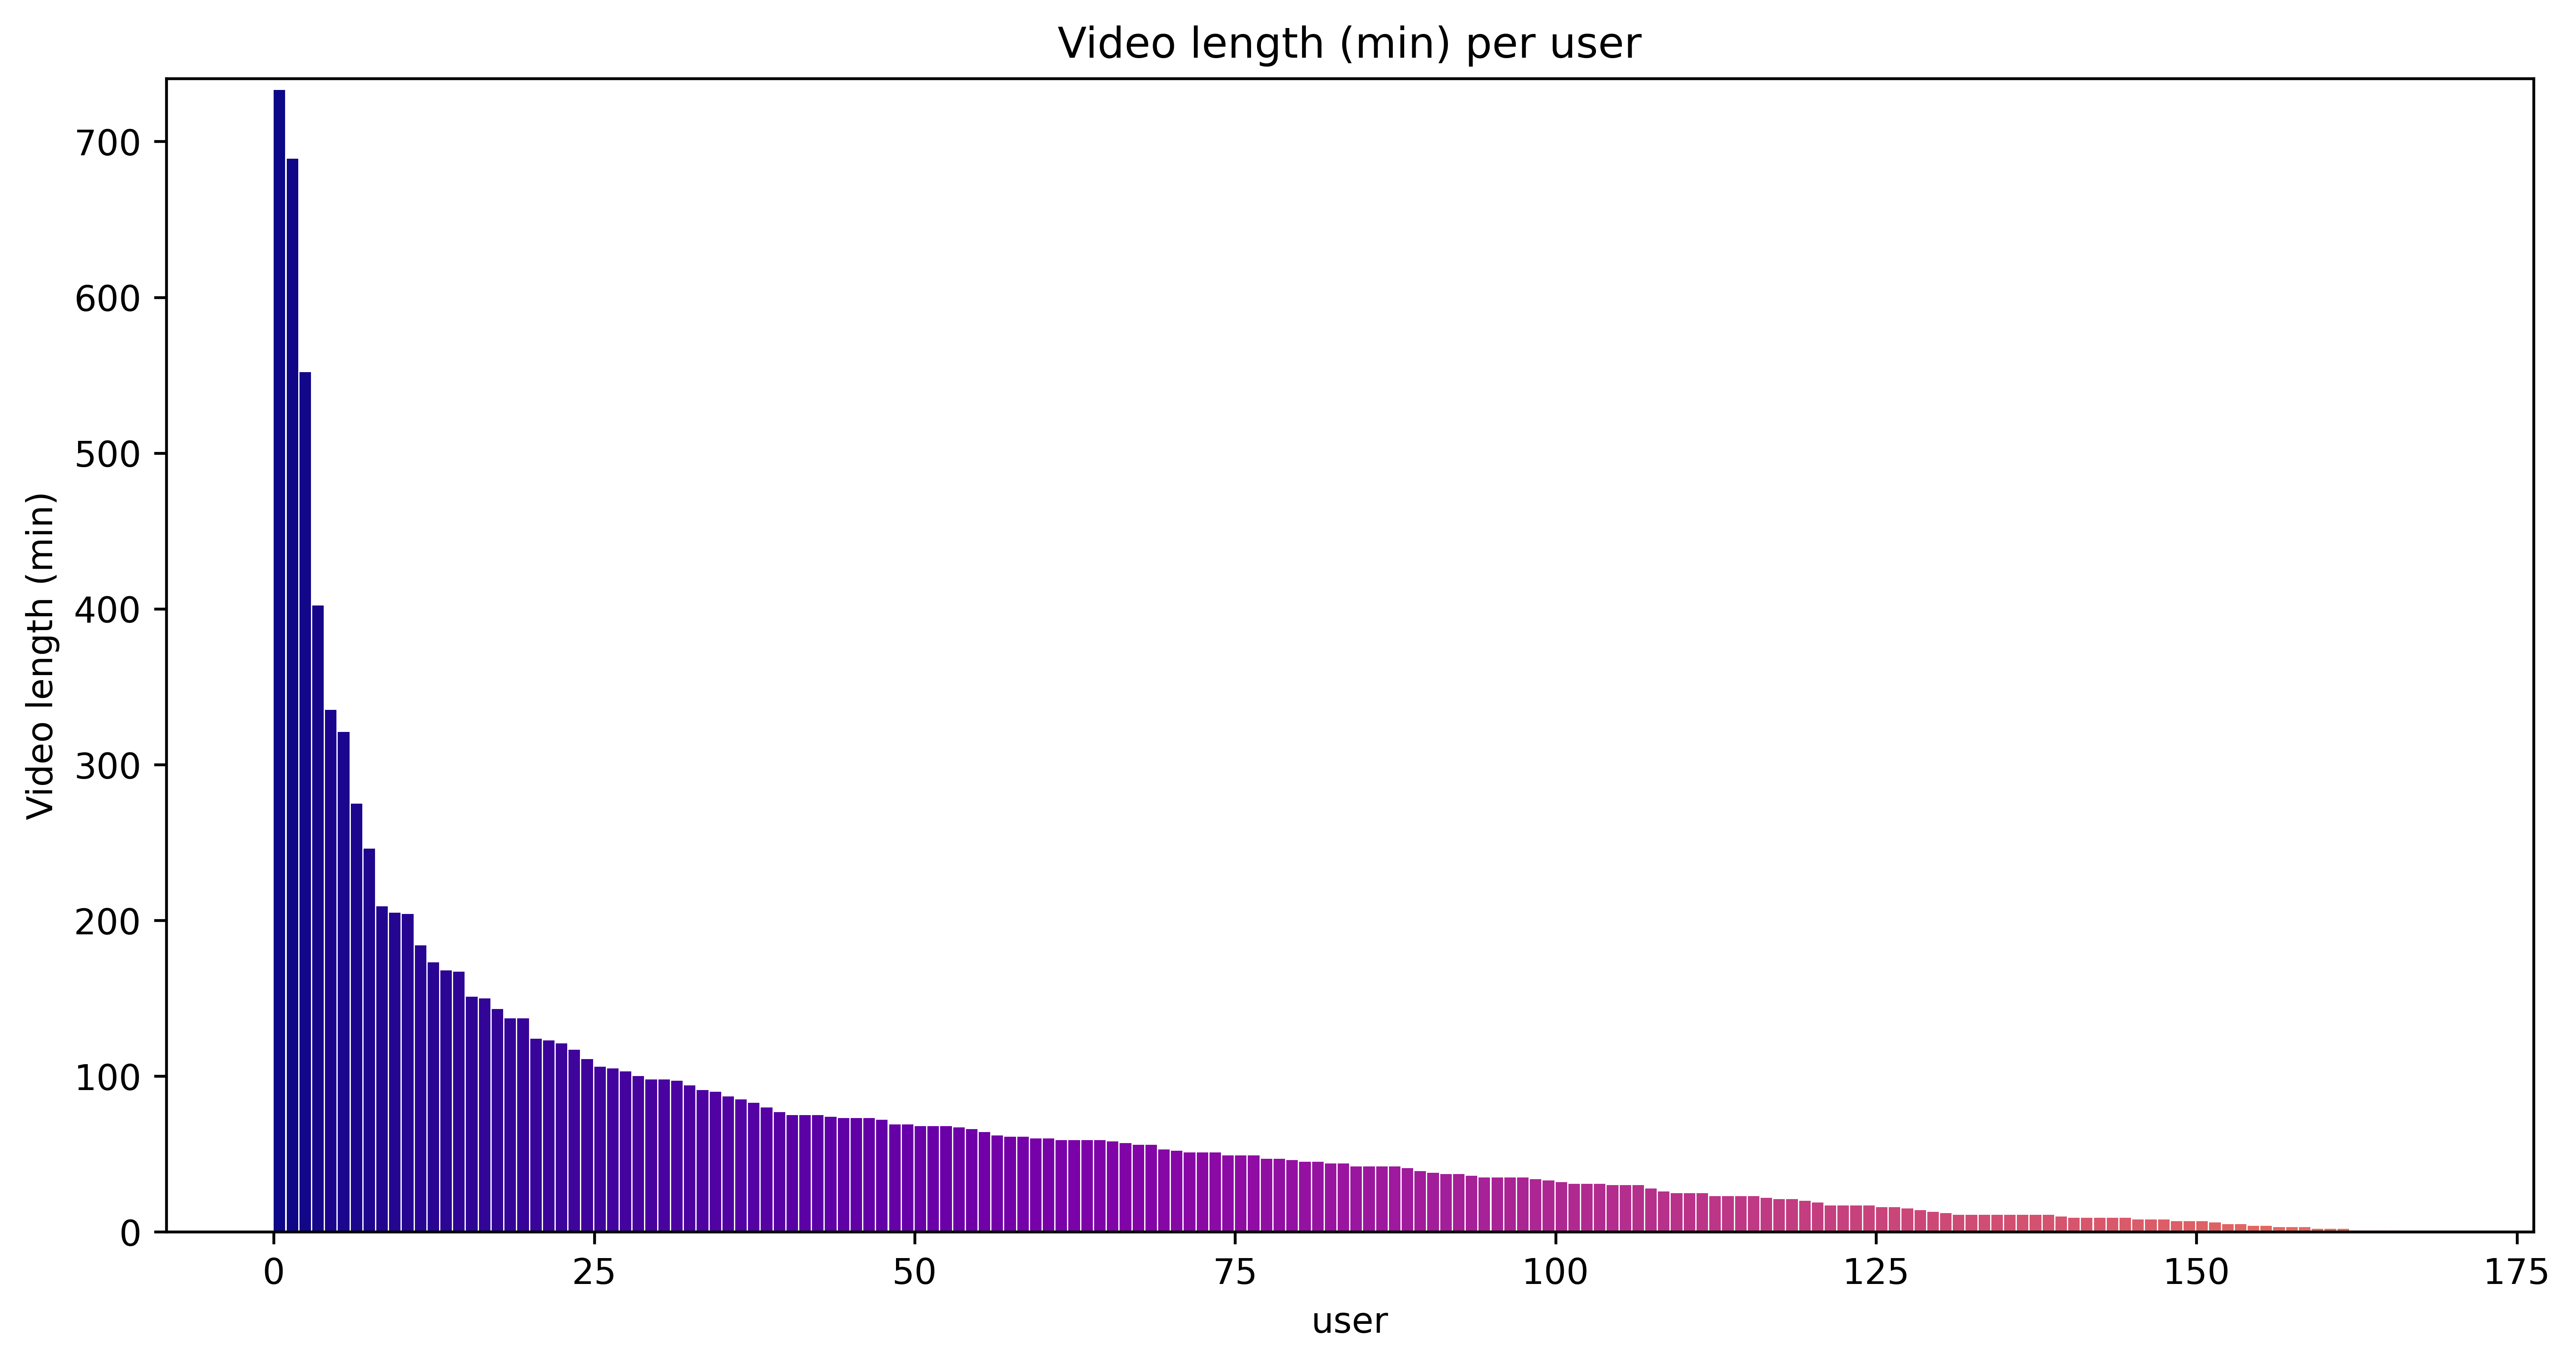

HEAD = [733, 689, 552, 402, 335, 321, 275, 246, 209, 205]...
TAIL = ...[3, 2, 2, 2, 1, 1, 1, 1, 0, 0]


<Figure size 432x288 with 0 Axes>

In [9]:
# Video lengths for this plot
# Barchart API: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar
def plot_barchart(x_axis, y_vals, title,ylabel,xlabel='User-ID', 
                  grid=False,yerror=None,xerror=None, y_labels=None, x_labels=None,bar_align='edge',barh=False,
                 figsize=(12, 6)):
    max_val = max(y_vals)
    my_cmap = plt.get_cmap("plasma")
    plt.figure(figsize=figsize, dpi=600) # So all bars are visible!
    
    if not barh:
        plt.bar(x_axis, height=y_vals,color=my_cmap.colors, align=bar_align,yerr=yerror,width=0.9)
    else:
        plt.barh(y_vals, width=x_axis,color=my_cmap.colors, align=bar_align,xerr=xerror,height=0.9)
        
    if x_labels:
        plt.xticks(x_axis, x_labels, rotation='vertical')
    if y_labels:
        plt.yticks(y_vals, y_labels)
    plt.ylim(None,max_val*1.01)
    plt.xlim(None,None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(grid)
    plt.show()
    plt.clf()
    
    print(f"HEAD = {y_vals[:10]}...")
    print(f"TAIL = ...{y_vals[-10:]}")
    
    
y_axis = [int(x/60) for x in video_lens_s]
x_axis = [idx for idx in range(len(video_lens_s))]
plot_barchart(x_axis, y_axis, title='Video length (min) per user',ylabel='Video length (min)',xlabel="user")
